# Pythonで学ぶ　応用ファイナンス

# 第３章　市場リスク分析

author{尚　晋}　date{JAN 24, 2022}

## 3.1 シングルインデックスモデル

1. シングルインデックスモデル
* 収益率を予測可能な部分と、予測できない部分に分ける.
    <ul> $r_i=E(r_i)+e_i$ </ul>
    <br>
* 全ての証券のリターンに影響を与える共通ファクター$𝑚$が存在すると考える。
    <ul> $r_i=E(r_i)+m+e_i$ </ul>
    <br>
* 企業によってマクロ経済のショックに対する反応は異なるので、感応度$\beta$で表す。
    <ul> $r_i=E(r_i)+\beta_i m+e_i$ </ul>
    <br>
* TOPIXなどのマーケットインデックスの収益率などをマクロ経済変数の代理変数として利用する。
    <ul> $R_i(t)=\alpha_i+\beta_iR_M(t)+e_i(t)$ </ul> 
    <br>
* $R_M$と$R_i$は超過リターンで、 
    <ul> $R_M=r_M-r_f$</ul> 
    <ul> $R_i=r_i-r_f$</ul> 
    <ul>で計算する</ul> 
    <ul>ここで、$r_f$はリスクフリーレートである。本章で10年物国債の利回りを使う。</ul>
<br>
2. データ

<table>
<thead>
<tr>
<th>株価</th>
<th>超過リターン</th>
<th>計算式</th>
</tr>
</thead>
    
<tbody>   
<tr>
<td>Asics</td>
<td>r1</td>
<td>dlog(asics)-m10y</td>
</tr>

<tr>
<td>GREE</td>
<td>r2</td>
<td>dlog(gree)-m10y</td>
</tr>
    
<tr>
<td>MUFJ</td>
<td>r3</td>
<td>dlog(mufj)-m10y</td>
</tr>

<tr>
<td>TGAS</td>
<td>r4</td>
<td>dlog(tgas)-m10y</td>
</tr>

<thead>
<tr>
<td>TOYOTA</td>
<td>r5</td>
<td>dlog(tgas)-m10y</td>
</tr>
</thead>

<tr>
<td>TOPIX</td>
<td>rtpx</td>
<td>dlog(topix)-m10y</td>
</tr>


</tbody>
</table>

<br>

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import warnings
warnings.filterwarnings("ignore")

#データの読み込み  Chap3.1_3.4_data_daily.csv
df = pd.read_csv(
    'D:\\Chrome Download\\07973_1\\Chap3_marketRiskAnalysis\\data\\Chap3.1_3.4_data_daily.csv',
    header=0)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) # set index
# df.index= df['Date']  #also set index, but will show two columns Date

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 733 entries, 2013-01-04 to 2015-12-30
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   topix   733 non-null    float64
 1   m10     733 non-null    float64
 2   asics   733 non-null    float64
 3   gree    733 non-null    float64
 4   mufj    733 non-null    float64
 5   tgas    733 non-null    float64
 6   toyota  733 non-null    float64
dtypes: float64(7)
memory usage: 45.8 KB


In [3]:
#インポートした国債利回り（日次）のデータはパーセント単位（半年複利の利回り）なので、
#対数階差で計算する収益率は年次なので、次の式で半年複利の利回りm10を年利に変更する。
#m10*0.01 小数に戻す
#df$m10*0.01/2 半年を年に変更
#1+df$m10*0.01/2　元本に
# (1+df$m10*0.01/2)^2　複利計算は二乗
# (1+df$m10*0.01/2)^2-1　金利の部分だけを取る
df['m10y'] = ((1+df['m10'] *0.01/2)**2-1)
df=df.dropna(axis=0,how='any') #欠損値を削除
# df =df.fillna(method='bfill') #欠損値を削除するほか、
df.head()

,topix,m10,asics,gree,mufj,tgas,toyota,m10y
Date,,,,,,,,
2013-01-04,888.51,0.835,1378.0,1381.0,484.0,2030.0,4260.0,0.008367
2013-01-07,881.06,0.835,1343.0,1435.0,476.0,2050.0,4185.0,0.008367
2013-01-08,871.88,0.825,1333.0,1416.0,462.0,2070.0,4100.0,0.008267
2013-01-09,879.05,0.825,1366.0,1385.0,469.0,2075.0,4165.0,0.008267
2013-01-10,889.02,0.825,1370.0,1382.0,474.0,2065.0,4205.0,0.008267


In [4]:
# print((2.1-1.5)/1.5) #0.4000000000000001
# print(np.log(2.1/1.5)) #0.336472236621213
# print(np.log(2.1)-np.log(1.5)) #0.33647223662121295

# method1 df['asics'].pct_change(1)-df['m10y']
# method2 (np.log(df['asics']/df['asics'].shift(1))-df['m10y']).dropna() 2=3 !=(not equal)1
# method3
(np.log(df['asics']).diff() - df['m10y']).dropna()

Date
2013-01-07   -0.034095
2013-01-08   -0.015741
2013-01-09    0.016188
2013-01-10   -0.005343
2013-01-11    0.010624
                ...   
2015-12-24   -0.020959
2015-12-25   -0.011593
2015-12-28   -0.003881
2015-12-29    0.008954
2015-12-30    0.003289
Length: 732, dtype: float64

In [5]:
# extract the column name
columns=df.drop(['m10','m10y'],axis=1).columns
columns

Index(['topix', 'asics', 'gree', 'mufj', 'tgas', 'toyota'], dtype='object')

In [6]:
ret_df=df[columns].copy() #計算した超過リターンを入れるデータフレームを準備しておく

#超過リターンを計算する
for i in columns:
    ret_df[i]=np.log(df[i]).diff() - df['m10y']
ret_df=ret_df.dropna() #delete the NaNs
ret_df.head() #check the results

,topix,asics,gree,mufj,tgas,toyota
Date,,,,,,
2013-01-07,-0.016788,-0.034095,0.029990,-0.025034,0.001437,-0.026130
2013-01-08,-0.018741,-0.015741,-0.021596,-0.038120,0.001442,-0.028787
2013-01-09,-0.000077,0.016188,-0.030403,0.006771,-0.005854,0.007462
2013-01-10,0.003011,-0.005343,-0.010435,0.002338,-0.013098,0.001291
2013-01-11,0.002642,0.010624,0.006904,0.002317,-0.008177,0.004818


In [7]:
#空白の結果の表を作り、後で推定したOLSの結果を書き込む準備をする
result_df = pd.DataFrame(columns=["ALPHA", "BETA"],
                                     index=[
                                         "ASICS", "ASICS_t", "GREE", "GREE_t", "MUFJ",
                                         "MUFJ_t", "TGAS", "TGAS_t", "TOYOTA", "TOYOTA_t"
                                     ])
result_df

,ALPHA,BETA
ASICS,NaN,NaN
ASICS_t,NaN,NaN
GREE,NaN,NaN
GREE_t,NaN,NaN
MUFJ,NaN,NaN
MUFJ_t,NaN,NaN
TGAS,NaN,NaN
TGAS_t,NaN,NaN
TOYOTA,NaN,NaN
TOYOTA_t,NaN,NaN


In [8]:
from scipy.optimize import leastsq
import statsmodels.api as sm

In [9]:
Y = ret_df['mufj']
X = ret_df['topix']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print("results.params as follows:#########################################")
print(results.params)
print("results.summary as follows:#########################################")
print(results.summary())
print("results.tvalues as follows#########################################")
print(results.tvalues)

results.params as follows:#########################################
const    0.000766
topix    1.194776
dtype: float64
results.summary as follows:#########################################
                            OLS Regression Results                            
Dep. Variable:                   mufj   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     1734.
Date:                Mon, 24 Jan 2022   Prob (F-statistic):          5.35e-195
Time:                        11:29:11   Log-Likelihood:                 2306.5
No. Observations:                 732   AIC:                            -4609.
Df Residuals:                     730   BIC:                            -4600.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef 

In [11]:
from scipy.optimize import leastsq
#それぞれの超過リターンのシングルインデックスモデルの推定

columns1 = df.drop(['m10', 'm10y', 'topix'], axis=1).columns
print(columns1)

X = ret_df['topix']
X = sm.add_constant(X)
Y = ret_df[columns1[0]]
model = sm.OLS(Y, X)
for i in range(5):
    Y = ret_df[columns1[i]]
    model = sm.OLS(Y, X)
    results = model.fit()
    result_df['ALPHA'][i * 2] = results.params[0]
    result_df['BETA'][i * 2] = results.params[1]
    result_df['ALPHA'][i * 2 + 1] = results.tvalues[0]
    result_df['BETA'][i * 2 + 1] = results.tvalues[1]
result_df

Index(['asics', 'gree', 'mufj', 'tgas', 'toyota'], dtype='object')


,ALPHA,BETA
ASICS,-0.000274,0.926803
ASICS_t,-0.351238,16.822481
GREE,-0.003596,0.649199
GREE_t,-3.620029,9.253145
MUFJ,0.000766,1.194776
MUFJ_t,1.885427,41.637915
TGAS,-0.001522,0.737564
TGAS_t,-3.491725,23.957768
TOYOTA,0.000245,1.049521
TOYOTA_t,0.803635,48.79292


## 3.2 マルチファクターモデル


<ul>
<li>個々の証券のリターンを各種マクロ経済ファクターの変化と感応度の積の和で表現する。</li>
</ul>
<ul>$
R_i(t)=\alpha_i+\beta_1 rgdp(t)+\beta_2ir(t)+e_i(t)
$
</ul>
</ol>
<ul>
<li>前節で感応度$\beta$が１を上回った、<b>マクロ要因 </b>によって売上に影響がありそうな<br>
 トヨタ自動車の株価収益率を使って、
	マルチファクターモデルを推定する。</li>
</ul>

### 3.2.1 直観的な方法によるデータの作成

<p>ここで、株価、国債の利回り：<b>月次データ</b>、
	GDP：<b>四半期データ</b>
	操作手順は次の通りである：</p>
<li>Yahoo！Financeからトヨタ自動車の株価（月次）を取得 </li>
<li>FREDから国債利回りデータ（月次）、GDPデータ（四半期）を取得 </li>
<li>GDPデータ（四半期）を月度に度数変換する </li>
<li>月次データを利用してマルチファクターモデルを推定する</li>

In [12]:
#データの読み込み Chap3.2_data_monthly-quarterly.xlsx
df_M = pd.read_csv(
    'D:\\Chrome Download\\07973_1\\Chap3_marketRiskAnalysis\\data\\Chap3.2_data_monthly.csv',
    header=0)
df_gdp_Q=pd.read_excel(
    'D:\\Chrome Download\\07973_1\\Chap3_marketRiskAnalysis\\data\\Chap3.2_data_monthly-quarterly.xlsx',
    header=0,
    sheet_name='Sheet1')
df_M['Date'] = pd.to_datetime(df_M['Date'])
df_M.set_index('Date', inplace=True)  # set index
df_gdp_Q['Date'] = pd.to_datetime(df_gdp_Q['Date'])
df_gdp_Q.set_index('Date', inplace=True)  # set index
print(df_M.head())
print(df_gdp_Q.head())
print(df_M.info())
print(df_gdp_Q.info())

            toyota  jp10b
Date                     
2000-01-01    4690  1.691
2000-02-01    4390  1.796
2000-03-01    5370  1.819
2000-04-01    5370  1.740
2000-05-01    4890  1.705
                 gdp
Date                
2000-01-01  479896.6
2000-04-01  482128.3
2000-07-01  482257.6
2000-10-01  486937.3
2001-01-01  490542.7
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2000-01-01 to 2016-12-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   toyota  204 non-null    int64  
 1   jp10b   204 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2000-01-01 to 2016-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gdp     68 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB
None


In [13]:
df_M['rtyt'] = np.log(df_M['toyota']).diff()*100  #calculate the monthly return of toyota stock
df_M['ir'] = np.log(df_M['jp10b']).diff()*100  #calculate the monthly return of interest rate
# df_M = df_M.dropna()
df_M.head()

,toyota,jp10b,rtyt,ir
Date,,,,
2000-01-01,4690,1.691,NaN,NaN
2000-02-01,4390,1.796,-6.610336,6.024190
2000-03-01,5370,1.819,20.149868,1.272493
2000-04-01,5370,1.740,0.000000,-4.440179
2000-05-01,4890,1.705,-9.363561,-2.032000


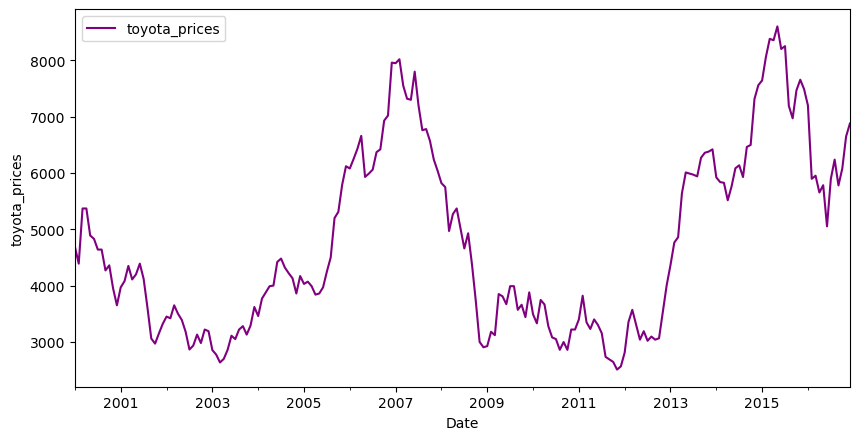

In [14]:
# Display the data
plt.figure(figsize=(10, 5), dpi=100)
df_M['toyota'].plot(label='toyota_prices',color='purple')
plt.xlabel('Date')
plt.ylabel('toyota_prices')
plt.legend()

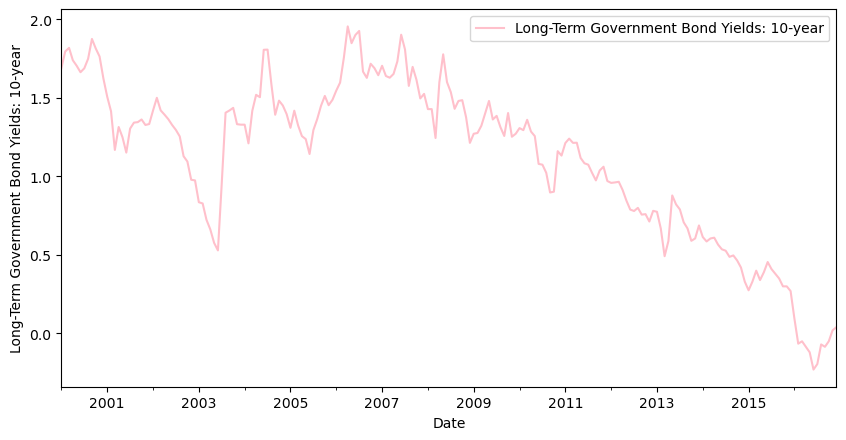

In [15]:
# Display the data
plt.figure(figsize=(10, 5), dpi=100)
df_M['jp10b'].plot(label='Long-Term Government Bond Yields: 10-year',color='pink')
plt.xlabel('Date')
plt.ylabel('Long-Term Government Bond Yields: 10-year')
plt.legend()

                 gdp
Date                
2000-01-01  479896.6
2000-04-01  482128.3
2000-07-01  482257.6
2000-10-01  486937.3
2001-01-01  490542.7
                      gdp
Date                     
2000-01-31  479896.600000
2000-02-29  481412.700275
2000-03-31  482077.923849
2000-04-30  482128.300000
2000-05-31  481933.337986
                 gdp
Date                
2015-10-01  538159.7
2016-01-01  541961.9
2016-04-01  540782.5
2016-07-01  541856.1
2016-10-01  543436.5
                      gdp
Date                     
2016-06-30  541150.532001
2016-07-31  541856.100000
2016-08-31  542619.209918
2016-09-30  543204.605952
2016-10-31  543436.500000


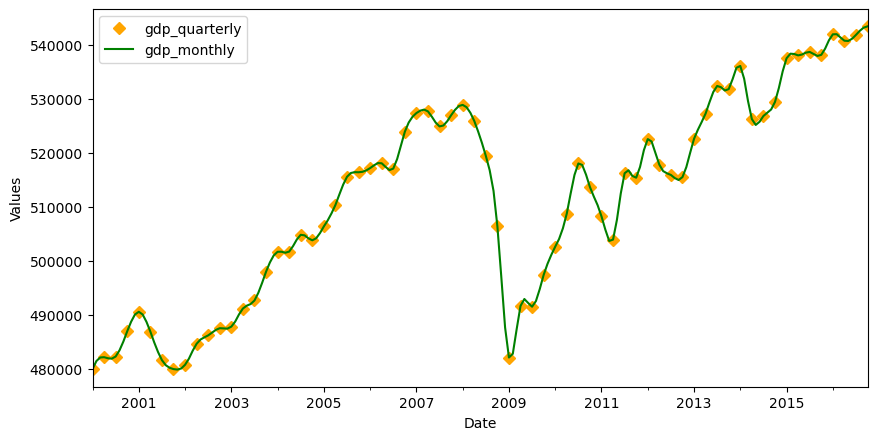

In [16]:
gdp_M = df_gdp_Q.resample('M').last().interpolate(method='cubic')  #[cubic interpolation]のメソッドで月次データに度数変換
print(df_gdp_Q.head(5))
print(gdp_M.head(5))
print(df_gdp_Q.tail(5))
print(gdp_M.tail(5))
# Display the fit
plt.figure(figsize=(10, 5), dpi=100)
df_gdp_Q['gdp'].plot(linestyle='none', marker='D', label='gdp_quarterly',color='orange')
gdp_M['gdp'].plot(label='gdp_monthly',color='green')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

202


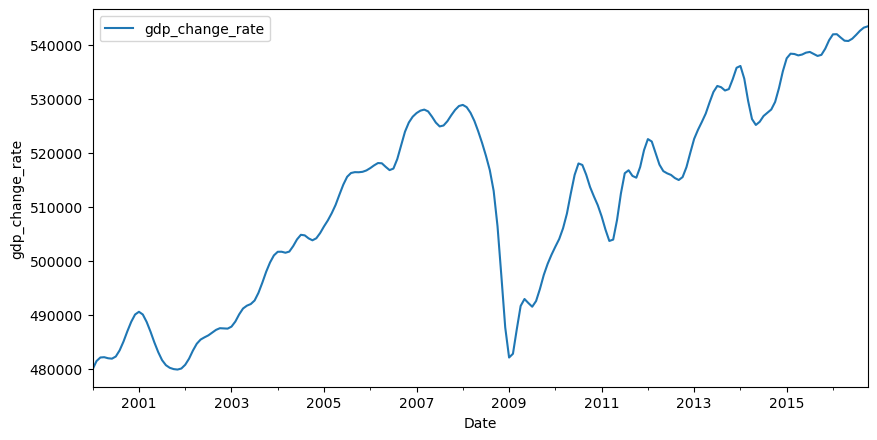

In [17]:
gdp_M['rgdp'] = np.log(gdp_M['gdp']).diff() * 100  #calculate the monthly change rate of gdp
# gdp_M = gdp_M.dropna()
print(len(gdp_M))
# Display the data
plt.figure(figsize=(10, 5), dpi=100)
gdp_M['gdp'].plot(label='gdp_change_rate')
plt.xlabel('Date')
plt.ylabel('gdp_change_rate')
plt.legend()

In [18]:
df_M=df_M.dropna()
df_M=df_M[0:192]
gdp_M=gdp_M.dropna()[0:192]
print(len(df_M))
print(len(gdp_M))

192
192


In [19]:
# merge(df_M['const'],df_M['ir'],gdp_M['rgdp'])
Y = df_M['rtyt']
df_M['const']=1
X=pd.merge(df_M,gdp_M['rgdp'].dropna(),on=df_M.index)
X.set_index('key_0', inplace=True)
print(X.head())
print(Y.head())

            toyota  jp10b       rtyt        ir  const      rgdp
key_0                                                          
2000-02-01    4390  1.796  -6.610336  6.024190      1  0.315424
2000-03-01    5370  1.819  20.149868  1.272493      1  0.138086
2000-04-01    5370  1.740   0.000000 -4.440179      1  0.010449
2000-05-01    4890  1.705  -9.363561 -2.032000      1 -0.040446
2000-06-01    4830  1.664  -1.234584 -2.434077      1 -0.016027
Date
2000-02-01    -6.610336
2000-03-01    20.149868
2000-04-01     0.000000
2000-05-01    -9.363561
2000-06-01    -1.234584
Name: rtyt, dtype: float64


In [20]:
X1=X[['const','rgdp','ir']]
X1.head()

            const      rgdp        ir
key_0                                
2000-02-01      1  0.315424  6.024190
2000-03-01      1  0.138086  1.272493
2000-04-01      1  0.010449 -4.440179
2000-05-01      1 -0.040446 -2.032000
2000-06-01      1 -0.016027 -2.434077


In [21]:
model1 = sm.OLS(Y,X1)
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rtyt   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     8.992
Date:                Mon, 24 Jan 2022   Prob (F-statistic):           0.000186
Time:                        11:29:12   Log-Likelihood:                -637.60
No. Observations:                 192   AIC:                             1281.
Df Residuals:                     189   BIC:                             1291.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0662      0.497      0.133      0.894      -0.915       1.047
rgdp           4.5754      1.284      3.563      0.000       2.042       7.109
ir             0.0885      0.038      2.308      0.022       0.013       0.164
==============================================================================
Omnibus:                        0.488   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.784   Jarque-Bera (JB):                0.592
Skew:                           0.112   Prob(JB):                        0.744
Kurtosis:                       2.844   Cond. No.                         33.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.2.2 ローリング回帰

<ol>
<li>ここまでは最小二乗法による回帰分析は、回帰係数の推定値は一定で変化がないと考え方。</li>
<li>しかし、リーマンショックや大震災などの負のショックや、<br>
    アベノミクスなどの一定期間持続性のある正の影響がある場合、</li>
<ul>
    <li>これらの回帰係数は変わるという視点から、ローリング回帰という手法を利用する。</li>
 <li>      
		$Y_i=\beta_0+\beta_1 X_i+\beta_2 Z_i+\mu_i$
 </li>
<li>window lengthを決めて、この期間のデータを用いて、一回目の推定を行い、<br>
    終了したら、時点を$n$期に移動して回帰を再実行する。</li></ul>
</ol>

In [22]:
#Rolling Regression必要のパケージ
import seaborn
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

rols = RollingOLS(Y, X1, window=60) #window sizeを60（5年間）に設定してローリング回帰を実行する
rres = rols.fit() 
params = rres.params.copy()
params.index = X1.index
params

,const,rgdp,ir
key_0,,,
2000-02-01,NaN,NaN,NaN
2000-03-01,NaN,NaN,NaN
2000-04-01,NaN,NaN,NaN
2000-05-01,NaN,NaN,NaN
2000-06-01,NaN,NaN,NaN
...,...,...,...
2015-09-01,1.333288,4.466329,0.151495
2015-10-01,1.537634,4.081520,0.138299
2015-11-01,1.293703,4.521718,0.107586


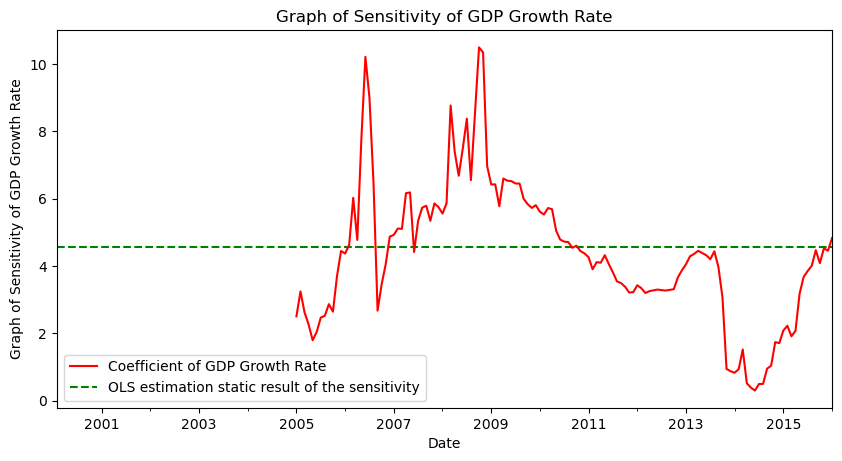

In [23]:
# Display the data #GDP成長率の感応度の推移グラフを描く
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Graph of Sensitivity of GDP Growth Rate',fontsize = 12)
params['rgdp'].plot(label='Coefficient of GDP Growth Rate',color='red')
#OLS推定結果の感応度をグラフに追加  results1.params[1]
plt.hlines(results1.params[1],xmin=X1.index[0],xmax=X1.index[len(X1)-1], linestyles='--', colors='g', label='OLS estimation static result of the sensitivity') 
plt.xlabel('Date')
plt.ylabel('Graph of Sensitivity of GDP Growth Rate')
plt.legend()

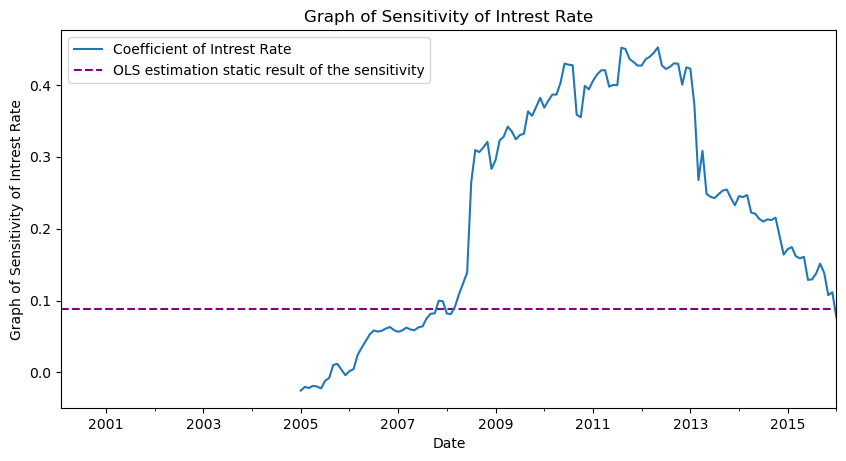

In [24]:
# Display the data #金利変化率の感応度の推移グラフを描く
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Graph of Sensitivity of Intrest Rate',fontsize = 12)
params['ir'].plot(label='Coefficient of Intrest Rate')
#OLS推定結果の感応度をグラフに追加  results1.params[2]
plt.hlines(results1.params[2],xmin=X1.index[0],xmax=X1.index[len(X1)-1], linestyles='--', colors='purple', label='OLS estimation static result of the sensitivity') 
plt.xlabel('Date')
plt.ylabel('Graph of Sensitivity of Intrest Rate')
plt.legend()

### 3.2.3 MIDAS回帰

1. ここまでは、四半期のLFデータにスプライン曲線をHFデータにフィットさせて、
    月次の架空データを作成して回帰分析を行う。
2. 観測度数の異なるデータを利用してモデル推定を行う
    MIDAS（Mixed Data Sampling）推定という回帰方法を紹介 
* メリット：HF、LFどちらに集約しなくても、データの確率的変動の情報を保ったまま、
    回帰分析に利用できる
  * $y_t=\beta_0+\beta_1 B(L^{1/m};\theta)x_t^{(m)}+\epsilon_t^{(m)}$
    -  $y_t$は年次頻度、$x_t$は四半期頻度、$m=4$。
    -  同様に、$y_t$は四半期頻度、$x_t$は月度頻度、$m=3$。
    -  ここで、$B(L)$はMIDAS回帰の四半期データの個別ラグに対応したパラメータ。
    -  $B(L^{1/m};\theta)=\Sigma_{k=0}^KB(k;\theta)L^{k/m}$。

#### 3.2.3  (1) MIDAS回帰 乱数で生成したデータで、quarter_y=intercept+quarter_z+month_x+errorの場合

In [25]:
import datetime
from sklearn import linear_model
import time
import warnings
warnings.filterwarnings("ignore")
clf = linear_model.LinearRegression()

In [26]:
Date_M = pd.date_range(("1990/1/1"), ("2010/12/31"), freq='m')
n = len(Date_M)

np.random.seed(10)
mu, sigma = 0, 1
e=np.random.normal(mu, sigma, n) #標準正規分布に従うｎ個の、平均値が０、標準偏差が１の乱数を生成する
x = 2*np.random.normal(mu, sigma, n)  #標準正規分布に従うｎ個の、平均値が０、標準偏差が１の、値が2倍となる乱数を生成する
z = 3*np.random.normal(mu, sigma, n)  #標準正規分布に従うｎ個の、平均値が０、標準偏差が１の、値が3倍となる乱数を生成する

b0 = 1  #ｙを作成するための係数を指定
b1 = 1.5  ##ｙを作成するための係数を指定
b2 = -0.7  ##ｙを作成するための係数を指定
y = b0+b1*x+b2*z+e  #ｙを作成する

x=pd.DataFrame(x,index=Date_M)
z=pd.DataFrame(z,index=Date_M)
X2=pd.merge(x,z,on=x.index)
X2.columns = ['Date', 'x','z']
X2.set_index('Date', inplace=True) 
X2=sm.add_constant(X2)

model2 = sm.OLS(y,X2)
results2 = model2.fit()
# results2.summary()  #ここで一度回帰して、ｚの係数が-0.7142であることを確認する

In [27]:
# Date_Q = pd.date_range(("1990/1/1"), ("2010/12/31"), freq='q')  ##1990年から2010年までの四半期日付のベクトルを用意する
# t = len(Date_Q)

y=pd.DataFrame(y,index=Date_M)
quarter_variables=pd.merge(y,z,on=y.index)
quarter_variables.columns = ['Date', 'y','z']
quarter_variables.set_index('Date', inplace=True)
# print(quarter_variables.head())

quarter_aggregate =quarter_variables.resample('Q').sum()  #HFをLFに集約する
# print(quarter_aggregate.head())

In [28]:
Y3=quarter_aggregate['y']
Z=quarter_aggregate['z']
Z=sm.add_constant(Z)

model3= sm.OLS(Y3,Z) #四半期頻度のデータで、zをyに単純なOLSを推定する
results3 = model3.fit()
# results3.summary()  #ここで一度回帰して、ｚの係数が-0.6017であることを確認する

In [29]:
quarter_y=pd.DataFrame(Y3,index=Y3.index)
quarter_y.columns = ['quarter_y']
quarter_z=quarter_aggregate['z']
quarter_z=pd.DataFrame(quarter_z,index=quarter_z.index)
quarter_z.columns = ['quarter_z']
month_x=pd.DataFrame(x,index=Date_M)
month_x.columns = ['month_x']

In [30]:
quarter_y.index = pd.to_datetime(quarter_y.index, format='%m/%d/%Y').strftime('%Y-%m-01')
month_x.index = pd.to_datetime(month_x.index, format='%m/%d/%Y').strftime('%Y-%m-01')
quarter_z.index = pd.to_datetime(quarter_z.index, format='%m/%d/%Y').strftime('%Y-%m-01')

In [31]:
df3 = pd.merge(quarter_y, month_x, left_index=True, right_index=True, how='outer')
df3=pd.merge(df3,quarter_z,left_index=True, right_index=True, how='outer')
df3.head()

,quarter_y,month_x,quarter_z
1990-01-01,NaN,-1.907065,NaN
1990-02-01,NaN,1.176081,NaN
1990-03-01,0.931654,0.137603,2.399629
1990-04-01,NaN,2.824129,NaN
1990-05-01,NaN,-1.372431,NaN


<AxesSubplot:>

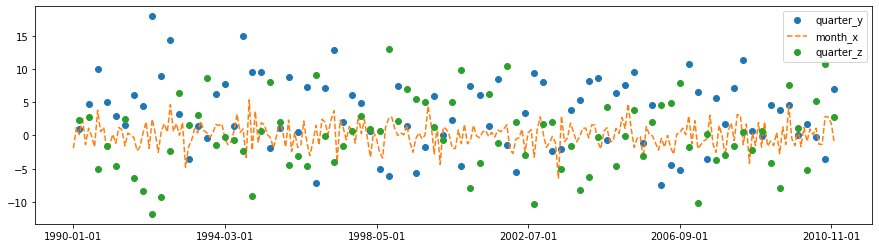

In [32]:
# Plot the sample data
df3[['quarter_y','month_x','quarter_z']].plot(figsize=(15,4), style=['o','--','o'])

In [33]:
df3['period'] = pd.to_datetime(df3.index.to_series()).apply(
    lambda x: 1 if x.month in [1, 4, 7, 10] else (2 if x.month in [2, 5, 8, 11] else 3))

# df3 = df3[df3.index != '1990-01-01']
df3.head()

,quarter_y,month_x,quarter_z,period
1990-01-01,NaN,-1.907065,NaN,1
1990-02-01,NaN,1.176081,NaN,2
1990-03-01,0.931654,0.137603,2.399629,3
1990-04-01,NaN,2.824129,NaN,1
1990-05-01,NaN,-1.372431,NaN,2


In [34]:
df4 = pd.DataFrame(columns=[
                   'quarter_y', 'month_x_Q1', 'month_x_Q2', 'month_x_Q3','quarter_z']) 
for date, quarter_y,quarter_z, month_x, period in zip(df3.index, df3.quarter_y,df3.quarter_z, df3.month_x, df3.period):
    if period == 1:
        q1 = month_x
    elif period == 2:
        q2 = month_x
    else:
        record = pd.Series([quarter_y, q1, q2, month_x,quarter_z],
                           index=df4.columns, name=date)
        df4 = df4.append(record)
df4.index.name = 'DATE'

In [35]:
df4.head()

,quarter_y,month_x_Q1,month_x_Q2,month_x_Q3,quarter_z
DATE,,,,,
1990-03-01,0.931654,-1.907065,1.176081,0.137603,2.399629
1990-06-01,4.806447,2.824129,-1.372431,1.095888,2.725425
1990-09-01,9.989841,-0.072765,-1.694033,3.804608,-5.078248
1990-12-01,5.018014,0.559211,1.240509,-2.137135,-1.518106
1991-03-01,2.884506,-1.445241,0.168279,-1.168910,-4.659252


In [36]:
# 目的変数(Y)、説明変数(X)
Y = np.array(df4['quarter_y'])
X = np.array(df4[['month_x_Q1', 'month_x_Q2', 'month_x_Q3','quarter_z']])

# 予測モデルを作成
clf.fit(X, Y)
clf.fit(X, Y).coef_

array([ 1.57846477,  1.49322526,  1.38219808, -0.68878792])

In [37]:
# 偏回帰係数
ab = pd.DataFrame({"Name": ['month_x_Q1', 'month_x_Q2', 'month_x_Q3','quarter_z'],
                  "Coefficients": clf.coef_}).sort_values(by='Coefficients')
for index, row in ab.iterrows():
    if row.Name == 'quarter_z':
        b4 = row.Coefficients
    if row.Name == 'month_x_Q3':
        b3 = row.Coefficients
    elif row.Name == 'month_x_Q2':
        b2 = row.Coefficients
    else:
        b1 = row.Coefficients
# 切片
print(clf.intercept_)
a = clf.intercept_
print(ab)

3.0828885440925156
         Name  Coefficients
3   quarter_z     -0.688788
2  month_x_Q3      1.382198
1  month_x_Q2      1.493225
0  month_x_Q1      1.578465


#### 3.2.3  (2) 実際のデータで、quarter_y=intercept+month_x+errorの場合#

In [38]:
gdp = pd.read_csv('D:\\Users\\Jupyter Notebook\\MixDataSampling-Japan_GDP\\opt\\import\\GDP_JAPAN.csv',
                  parse_dates=['DATE'], index_col='DATE')
#鉱工業指数（生産指数) iip
iip = pd.read_csv('D:\\Users\\Jupyter Notebook\\MixDataSampling-Japan_GDP\\opt\\import\\IIP.csv', parse_dates=['DATE'], index_col='DATE')

In [39]:
gdp.index = pd.to_datetime(gdp.index, format='%m/%d/%Y').strftime('%Y-%m-01')
iip.index = pd.to_datetime(iip.index, format='%m/%d/%Y').strftime('%Y-%m-01')

df = pd.merge(gdp, iip, left_index=True, right_index=True, how='outer')
df.head()

,GDP_CYOY,IIP_YOY
DATE,,
2013-01-01,1.3,-5.6
2013-02-01,NaN,-6.1
2013-03-01,NaN,10.4
2013-04-01,1.4,-2.9
2013-05-01,NaN,-2.1


<AxesSubplot:xlabel='DATE'>

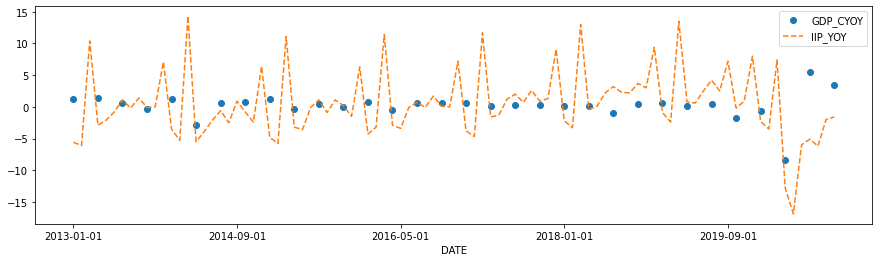

In [40]:
# Plot the sample data
df[['GDP_CYOY','IIP_YOY']].plot(figsize=(15,4), style=['o','--'])

In [41]:
df['period'] = pd.to_datetime(df.index.to_series()).apply(
    lambda x: 3 if x.month in [1, 4, 7, 10] else (1 if x.month in [2, 5, 8, 11] else 2))

df = df[df.index != '2013-01-01']

In [42]:
df2 = pd.DataFrame(columns=[
                   'GDP_CYOY', 'IIP_YOY_Q1', 'IIP_YOY_Q2', 'IIP_YOY_Q3'])
for date, GDP_CYOY, IIP_YOY, period in zip(df.index, df.GDP_CYOY, df.IIP_YOY, df.period):
    if period == 1:
        q1 = IIP_YOY
    elif period == 2:
        q2 = IIP_YOY
    else:
        record = pd.Series([GDP_CYOY, q1, q2, IIP_YOY],
                           index=df2.columns, name=date)
        df2 = df2.append(record)
df2.index.name = 'DATE'

In [43]:
df2.head()

,GDP_CYOY,IIP_YOY_Q1,IIP_YOY_Q2,IIP_YOY_Q3
DATE,,,,
2013-04-01,1.4,-6.1,10.4,-2.9
2013-07-01,0.6,-2.1,-0.8,1.1
2013-10-01,-0.3,-0.2,1.4,-0.1
2014-01-01,1.3,0.0,7.1,-3.5
2014-04-01,-2.8,-5.3,14.3,-5.5


In [44]:
# 目的変数(Y)、説明変数(X)
Y = np.array(df2['GDP_CYOY'])
X = np.array(df2[['IIP_YOY_Q1', 'IIP_YOY_Q2', 'IIP_YOY_Q3']])

# 予測モデルを作成
clf.fit(X, Y)
clf.fit(X, Y).coef_

array([-0.30522824, -0.05012821,  0.3563465 ])

0.20947307695146347


<AxesSubplot:xlabel='DATE'>

<Figure size 432x288 with 0 Axes>

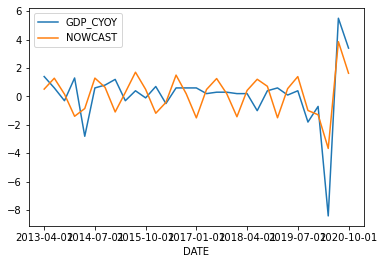

In [45]:
# 偏回帰係数
ab = pd.DataFrame({"Name": ['IIP_YOY_Q1', 'IIP_YOY_Q2', 'IIP_YOY_Q3'],
                  "Coefficients": clf.coef_}).sort_values(by='Coefficients')
for index, row in ab.iterrows():
    if row.Name == 'IIP_YOY_Q3':
        b3 = row.Coefficients
    elif row.Name == 'IIP_YOY_Q2':
        b2 = row.Coefficients
    else:
        b1 = row.Coefficients
# 切片
print(clf.intercept_)
a = clf.intercept_

df2['NOWCAST'] = df2.apply(lambda x: a + b1*x['IIP_YOY_Q1'] +
                           b2*x['IIP_YOY_Q2'] + b3*x['IIP_YOY_Q3'], axis=1)

newdf2 = df2.copy()
newdf2 = newdf2.drop('IIP_YOY_Q1', axis=1)
newdf2 = newdf2.drop('IIP_YOY_Q2', axis=1)
newdf2 = newdf2.drop('IIP_YOY_Q3', axis=1)
plt.figure()
newdf2.plot()

#### 3.2.3  (3) 実際のデータで、quarter_y=intercept+quarter_z+month_x+errorの場合

In [46]:
gdp = pd.read_csv(
    'D:\\Users\\Jupyter Notebook\\MixDataSampling-Japan_GDP\\opt\\import\\GDP_JAPAN.csv',
    parse_dates=['DATE'],
    index_col='DATE')
#鉱工業指数（生産指数) iip
iip = pd.read_csv(
    'D:\\Users\\Jupyter Notebook\\MixDataSampling-Japan_GDP\\opt\\import\\IIP.csv',
    parse_dates=['DATE'],
    index_col='DATE')
quarter_dummy=gdp*(-0.61)

In [47]:
gdp.index = pd.to_datetime(gdp.index, format='%m/%d/%Y').strftime('%Y-%m-01')
iip.index = pd.to_datetime(iip.index, format='%m/%d/%Y').strftime('%Y-%m-01')
quarter_dummy.index = pd.to_datetime(quarter_dummy.index, format='%m/%d/%Y').strftime('%Y-%m-01')

In [48]:
df = pd.merge(gdp, iip, left_index=True, right_index=True, how='outer')
df=pd.merge(df,quarter_dummy,left_index=True, right_index=True, how='outer')
df.head()

,GDP_CYOY_x,IIP_YOY,GDP_CYOY_y
DATE,,,
2013-01-01,1.3,-5.6,-0.793
2013-02-01,NaN,-6.1,NaN
2013-03-01,NaN,10.4,NaN
2013-04-01,1.4,-2.9,-0.854
2013-05-01,NaN,-2.1,NaN


<AxesSubplot:xlabel='DATE'>

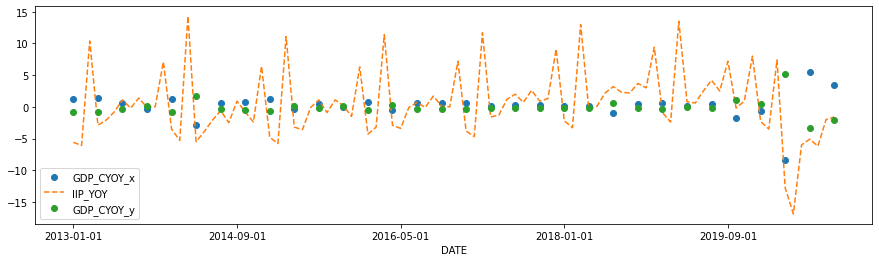

In [49]:
# Plot the sample data
df[['GDP_CYOY_x','IIP_YOY','GDP_CYOY_y']].plot(figsize=(15,4), style=['o','--','o'])

In [50]:
df['period'] = pd.to_datetime(df.index.to_series()).apply(
    lambda x: 3 if x.month in [1, 4, 7, 10] else (1 if x.month in [2, 5, 8, 11] else 2))

df = df[df.index != '2013-01-01']
df.head()

,GDP_CYOY_x,IIP_YOY,GDP_CYOY_y,period
DATE,,,,
2013-02-01,NaN,-6.1,NaN,1
2013-03-01,NaN,10.4,NaN,2
2013-04-01,1.4,-2.9,-0.854,3
2013-05-01,NaN,-2.1,NaN,1
2013-06-01,NaN,-0.8,NaN,2


In [51]:
df2 = pd.DataFrame(columns=[
                   'GDP_CYOY_x', 'IIP_YOY_Q1', 'IIP_YOY_Q2', 'IIP_YOY_Q3','GDP_CYOY_y'])
for date, GDP_CYOY_x,GDP_CYOY_y, IIP_YOY, period in zip(df.index, df.GDP_CYOY_x,df.GDP_CYOY_y, df.IIP_YOY, df.period):
    if period == 1:
        q1 = IIP_YOY
    elif period == 2:
        q2 = IIP_YOY
    else:
        record = pd.Series([GDP_CYOY_x, q1, q2, IIP_YOY,GDP_CYOY_y],
                           index=df2.columns, name=date)
        df2 = df2.append(record)
df2.index.name = 'DATE'

In [52]:
df2.head()

,GDP_CYOY_x,IIP_YOY_Q1,IIP_YOY_Q2,IIP_YOY_Q3,GDP_CYOY_y
DATE,,,,,
2013-04-01,1.4,-6.1,10.4,-2.9,-0.854
2013-07-01,0.6,-2.1,-0.8,1.1,-0.366
2013-10-01,-0.3,-0.2,1.4,-0.1,0.183
2014-01-01,1.3,0.0,7.1,-3.5,-0.793
2014-04-01,-2.8,-5.3,14.3,-5.5,1.708


In [53]:
# 目的変数(Y)、説明変数(X)
Y = np.array(df2['GDP_CYOY_x'])
X = np.array(df2[['IIP_YOY_Q1', 'IIP_YOY_Q2', 'IIP_YOY_Q3','GDP_CYOY_y']])

# 予測モデルを作成
clf.fit(X, Y)
clf.fit(X, Y).coef_

array([-3.65714128e-16, -1.22017573e-16,  5.43459239e-16, -1.63934426e+00])

In [54]:
# 偏回帰係数
ab = pd.DataFrame({"Name": ['IIP_YOY_Q1', 'IIP_YOY_Q2', 'IIP_YOY_Q3','GDP_CYOY_y'],
                  "Coefficients": clf.coef_}).sort_values(by='Coefficients')
for index, row in ab.iterrows():
    if row.Name == 'GDP_CYOY_y':
        b4 = row.Coefficients
    if row.Name == 'IIP_YOY_Q3':
        b3 = row.Coefficients
    elif row.Name == 'IIP_YOY_Q2':
        b2 = row.Coefficients
    else:
        b1 = row.Coefficients
# 切片
print(clf.intercept_)
a = clf.intercept_
print(ab)

5.551115123125783e-16
         Name  Coefficients
3  GDP_CYOY_y -1.639344e+00
0  IIP_YOY_Q1 -3.657141e-16
1  IIP_YOY_Q2 -1.220176e-16
2  IIP_YOY_Q3  5.434592e-16


In [59]:
# df2['NOWCAST'] = df2.apply(lambda x: a + b1*x['IIP_YOY_Q1'] +
#                            b2*x['IIP_YOY_Q2'] + b3*x['IIP_YOY_Q3']+b4*x['GDP_CYOY_y'], axis=1)

# newdf2 = df2.copy()
# newdf2 = newdf2.drop('IIP_YOY_Q1', axis=1)
# newdf2 = newdf2.drop('IIP_YOY_Q2', axis=1)
# newdf2 = newdf2.drop('IIP_YOY_Q3', axis=1)
# newdf2 = newdf2.drop('GDP_CYOY_y', axis=1)
# plt.figure()
# newdf2.plot(figsize=(15,4), style=['o','--','o'])

In [56]:
# # !pip3 install quandl
# import quandl
# quandl.ApiConfig.api_key = 'your key'
# oil=quandl.get('NSE/OIL')
# print(oil.head(3))
# # mydata = quandl.get(“FRED/GDP”, start_date=”2019-12-31″, end_date=”2020-9-26″)
# # df.to_csv (‘Name.csv’)
# 
# #https://algotrading101.com/learn/quandl-guide/
# # https://data.nasdaq.com/
# 
# # !pip3 install Nasdaq-Data-Link
# import nasdaqdatalink
# mydata = nasdaqdatalink.get("EIA/PET_RWTC_D") #WTI oil
# q_GDP=nasdaqdatalink.get("ODA/JPN_NGDPD") #GDP annually
# print(q_GDP.head(3))

<p>Emphasis, aka italics, with  <i> i or em tag</i></p>
<p>Strong emphasis, aka bold, <b>b or strong tag</b></p>
<p>Combined emphasis with <b><i> both tags </b></i></p>
<p>Strikethrough uses <strike> strike tag </strike> </p>

<li>収益率を予測可能な部分と、予測できない部分に分ける.</li>
<ul>$r_i=E(r_i)+e_i$ </ul>
<li>全ての証券のリターンに影響を与える共通ファクター$𝑚$が存在すると考える。</li>
<ol>$r_i=E(r_i)+m+e_i$</ol>
<li>企業によってマクロ経済のショックに対する反応は異なるので、感応度$\beta$で表す。</li>
<ul><ol>$r_i=E(r_i)+\beta_i m+e_i$</ol></ul>

1. Item 1
2. Item 2 ( we can type 1. and the markdown will automatically numerate them) 
* First Item
  * Nested item 1
  * Nested item 2
    1. Keep going
    1. Yes
  
* Second Item
- First Item
- Second Item

<ol>
<li>Item 1</li>
<li>Item 2 ( we can type 1. and the markdown will automatically numerate them) </li>
<li><p>First Item</p>
<ul>
<li>Nested item 1</li>
<li>Nested item 2<ol>
<li>Keep going</li>
<li>Yes</li>
</ol>
</li>
</ul>
</li>
<li><p>Second Item</p>
</li>
<li>First Item</li>
<li>Second Item</li>
</ol>